## Import Libraries and Data

In [40]:
# Data Analysis and Wrangling
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Add, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay



## Preprocessing
In the preprocessing step, we define the categorical and numerical columns that we intend to process further.

- **Target column**: The **obesity category (NObeyesdad)** is the target feature we want to predict in this case (e.g., normal weight, overweight level I, etc.).

- **Categorical features**: We apply **one-hot encoding** including target column (by using <code>to_categorical</code>) instead of label encoding since deep learning models are capable of handling high-dimensional data efficiently.

- **Numerical features**: We apply **standardization** by subtracting the mean and dividing by the standard deviation for each feature. This ensures that no single feature disproportionately influences the model due to scale differences.

Finally, we split the dataset into a **20% test set**, **~10% validation set** and an **~70% training set**, which is a typical ratio used in machine learning.

In [3]:
DATA_PATH = 'data/train.csv'

df = pd.read_csv(DATA_PATH)
df = df.drop('id', axis=1)
print(f'Sample size: {len(df)}, Data shape: {df.shape}')
df.head()


Sample size: 20758, Data shape: (20758, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
categorical_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_columns = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF', 'TUE']

# Label Encoding for the target column
le = LabelEncoder()
df['NObeyesdad'] = le.fit_transform(df['NObeyesdad'])
display(le.classes_)

# One-Hot Encoding for the categorical columns & normalize the numerical columns
numerical_pipeline = Pipeline([('scaler', StandardScaler())])
categorical_pipeline = Pipeline([('onehot', OneHotEncoder())])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Extract the features and target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)  # 0.125 * 80% = 10%

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_val_transformed = preprocessor.transform(X_val)

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)

print(f'X_train shape before: {X_train.shape} -> after transformation: {X_train_transformed.shape}')
print(f'X_test shape before: {X_test.shape} -> after transformation: {X_test_transformed.shape}')
print(f'X_val shape before: {X_val.shape} -> after transformation: {X_val_transformed.shape}')

array(['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I',
       'Overweight_Level_II'], dtype=object)

X_train shape before: (14530, 16) -> after transformation: (14530, 29)
X_test shape before: (4152, 16) -> after transformation: (4152, 29)
X_val shape before: (2076, 16) -> after transformation: (2076, 29)


In [50]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000, decay_rate=0.9)

model = Sequential([
    Input(shape=(29,)),
    Dense(128, activation="relu", kernel_initializer=HeUniform()),
    Dropout(0.2),
    Dense(64, activation="relu", kernel_initializer=HeUniform()),
    Dense(7, activation="softmax")
])
model.summary()
model.compile(optimizer=Adam(learning_rate=lr_schedule), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,551 (49.03 KB)

 Trainable params: 12,551 (49.03 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
callback = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=1e-3, restore_best_weights=True)

model.fit(X_train_transformed, y_train,
          validation_data=(X_val_transformed, y_val),
          epochs=100,
          batch_size=32,
          callbacks=[callback])
model.save('../../models/obesity_model.keras')

Epoch 1/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2604 - loss: 1.9898 - val_accuracy: 0.6093 - val_loss: 1.1095
Epoch 2/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.5784 - loss: 1.1149 - val_accuracy: 0.6965 - val_loss: 0.8416
Epoch 3/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.6580 - loss: 0.8919 - val_accuracy: 0.7327 - val_loss: 0.7167
Epoch 4/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.6967 - loss: 0.7820 - val_accuracy: 0.7697 - val_loss: 0.6394
Epoch 5/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.7301 - loss: 0.6984 - val_accuracy: 0.7938 - val_loss: 0.5867
Epoch 6/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7575 - loss: 0.6410 - val_accuracy: 0.8088 - val_loss: 0.5463
Epoch 7/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.7580 - loss: 0.6084 - val_accuracy: 0.8208 - val_loss: 0.5172
Epoch 8/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7735 - loss: 0.5

130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.8694 - loss: 0.3899
Test Loss: 0.3942
Test Accuracy: 86.73%
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
['Obesity_Type_III' 'Overweight_Level_I' 'Obesity_Type_I' ...
 'Obesity_Type_I' 'Overweight_Level_I' 'Overweight_Level_II']


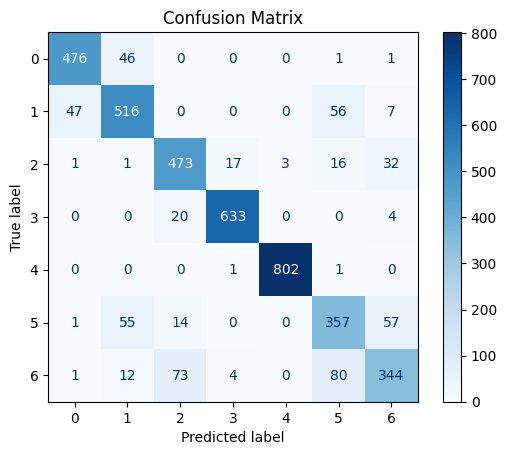

In [52]:
loss, accuracy = model.evaluate(X_test_transformed, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Visualize the predictions
y_pred_temp = model.predict(X_test_transformed)
y_pred_temp = np.argmax(y_pred_temp, axis=1)
y_pred_temp = le.inverse_transform(y_pred_temp)

y_test_temp = np.argmax(y_test, axis=1)
y_test_temp = le.inverse_transform(y_test_temp)
print(y_test_temp)

cm = confusion_matrix(y_test_temp, y_pred_temp)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(7))
cm_display.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()